# Contents and why we need this lab

This lab is about implementing neural networks yourself before we start using other frameworks which hide some of the computation from you. It builds on the first lab where you derived the equations for neural network forward and backward propagation and gradient descent parameter updates. 

All the frameworks for deep learning you will meet from now on uses automatic differentiation (autodiff) so you don't have to code the backward step yourself. In this version of this lab you will develop your own autodif implementation. We also have a [version](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/2_Feedforward_NumPy/2.1-FNN-NumPy.ipynb) of this lab where you have to code the backward pass explicitly in Numpy.

# External sources of information

1. Jupyter notebook. You can find more information about Jupyter notebooks [here](https://jupyter.org/). It will come as part of the [Anaconda](https://www.anaconda.com/) Python installation. 
2. [NumPy](https://numpy.org/). Part of Anaconda distribution. If you already know how to program most things about Python and NumPy can be found through Google search.
3. [Nanograd](https://github.com/rasmusbergpalm/nanograd) is a minimalistic version of autodiff developed by Rasmus Berg Palm that we use for our framework.


# This notebook will follow the next steps:

1. Nanograd automatic differentiation framework
2. Finite difference method
3. Data generation
4. Defining and initializing the network
5. Forward pass
6. Training loop 
7. Testing your model
8. Further extensions

# Nanograd automatic differention framework

The [Nanograd](https://github.com/rasmusbergpalm/nanograd) framework defines a class Var which both holds a value and gradient value that we can use to store the intermediate values when we apply the chain rule of differentiation.

In [117]:
# Copy and pasted from https://github.com/rasmusbergpalm/nanograd/blob/main/nanograd.py

from math import exp, log

class Var:
    """
    A variable which holds a float and enables gradient computations.
    """

    def __init__(self, val: float, grad_fn=lambda: []):
        assert type(val) == float
        self.v = val
        self.grad_fn = grad_fn
        self.grad = 0.0

    def backprop(self, bp):
        self.grad += bp
        for input, grad in self.grad_fn():
            input.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v + other.v, lambda: [(self, 1.0), (other, 1.0)])

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v * other.v, lambda: [(self, other.v), (other, self.v)])

    def __pow__(self, power):
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, lambda: [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)

    def relu(self):
        return Var(self.v if self.v > 0.0 else 0.0, lambda: [(self, 1.0 if self.v > 0.0 else 0.0)])
    
    def sigmoid(self):
        return Var(1/(1+exp(-self.v)), lambda: [(self, exp(self.v)/((exp(self.v)+1)**2))])

    def tanh(self):
        return Var((exp(2*self.v)-1)/(exp(2*self.v)+1), lambda: [(self, 4/((exp(-self.v)+exp(self.v))**2))])

    def identity(self):
        return Var(self.v, lambda: [(self, 1.0)])
    
    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])

    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])


A few examples illustrate how we can use this:

In [ ]:
a = Var(3.0)
b = Var(5.0)
f = a * b

f.backward()

for v in [a, b, f]:
    print(v)

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)


In [ ]:
a = Var(3.0)
b = Var(5.0)
c = a * b
d = Var(9.0)
e = a * d
f = c + e

f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=14.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


## Exercise a) What is being calculated?

Explain briefly the output of the code? What is the expression we differentiate and with respect to what variables?

**Answer (a)**

The result Var($v$,grad) tells you the value $v$ of that defined object, and grad tells you how much the factor in which the value has changed. For example for $a$ in cell [5], $v=3.0$, and grad$=14$, as $14*a.v=42$, as $f=a*d+a*b$, therefore $a=d+b$. That is $∂f/∂a=d+b=14$. So $a$, $b$ and $d$ are the independent variables in this case, and $c$, $e$, and $f$ the dependent ones. 

And for completeness sake: $∂f/∂b=∂f/∂d=a=3$.

## Exercise b) How does the backward function work?

You need to understand how the backward function calculates the gradients. We can use the two examples above to help with that.

Go through the following four steps and answer the questions on the way:

1. We represent the two expressions as graphs as shown below. Fill in the missing expressions for the different derivatives.

2. In the remainder consider the first expression. Make a schematic of the data structure which is generated when we define the expression for f. 

3. Then execute the backward function by hand to convince yourself that it indeed calculates the gradients with respect to the variables. 

4. Write down the sequence of calls to backprop.

**Answer (b)**

The answer provided for exercise (a), assuming it is correct, pretty much describes what happens, and the procedure behind the code, so I refer to there and to the graphviz diagrams of the data schematics for section (b1), (b2), and (b3).

**(b4)** The sequence of calls to backprop is:

1. f.backward() is called

2. f.grad is set to $∂f/∂f=1$

3. Since $f$ is defined as $c+e$, which is stored in f.grad_fn, the backprop moves on to these objects. $c$ is here calculated/shown first in step (4), but $c$ and $e$ could be interchanged, meaning the following steps (4) and (5) could be interchanged regardless.

4. c.grad is set to 1, since $∂f/∂c=1$. $c$ is defined as $c=a*b$, and backprop then moves onto these objects.

  4.1 Starting with $a$, since $∂c/∂a=b=5$, a.grad is set to 5.

  4.2 Now $b$, since $∂c/∂b=a=3$, b.grad is set to 3.

5. e.grad is set to 1, since $∂f/∂e=1$. $e$ is defined as $e=a*d$, and, same as (4), backprop then moves onto these objects.

  5.1 Since $∂e/∂a=d=9$, a.grad would be set to 9, but since a.grad is already set to 5, it therefore becomes a.grad$=d+b=9+5=14$

  5.2 $∂e/∂d=a=3$, so d.grad is set to 3.

Which concludes the f.backprop()


In [2]:
# import logging
import graphviz

#logging.basicConfig(format='[%(levelname)s@%(name)s] %(message)s', level=logging.DEBUG)

#graphviz.__version__, graphviz.version()

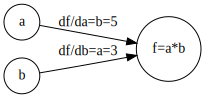

In [4]:
e1 = graphviz.Digraph('first expression', filename='fsm.gv')

e1.attr(rankdir='LR', size='8,5')

e1.attr('node', shape='circle')
e1.edge('a', 'f=a*b', label='df/da=b=5')
e1.edge('b', 'f=a*b', label='df/db=a=3')

e1

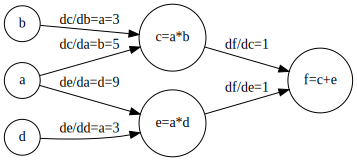

In [9]:
e2 = graphviz.Digraph('second expression', filename='fsm.gv')

e2.attr(rankdir='LR', size='8,5')

e2.attr('node', shape='circle')
e2.edge('a', 'c=a*b', label='dc/da=b=5')
e2.edge('b', 'c=a*b', label='dc/db=a=3')
e2.edge('a', 'e=a*d', label='de/da=d=9')
e2.edge('d', 'e=a*d', label='de/dd=a=3')
e2.edge('c=a*b', 'f=c+e', label='df/dc=1')
e2.edge('e=a*d', 'f=c+e', label='df/de=1')

e2

## Exercise c) What happens if we run backward again?

Try to execute the code below. Explain what happens.

In [ ]:
f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=28.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)


**Answer (c)**

The gradient is multiplied by 2, as the same gradients are calculated, and are added back to the variable gradient (from code: bp*grad, and bp=2, for the number of backpropagations done).

## Exercise d) Zero gradient

We can zero the gradient by backpropagating a -1.0 as is shown in the example below. (If you have run backward multiple time then you also have to run the cell below an equal amount of times.) Explain what is going on.

In [ ]:
a = Var(2.0)

for v in [a, b, c, d, e, f]:
    print(v)

f.backprop(-1.0)

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)
Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


**Answer (d)**

Even though a is redefined, the old a is still used/saved in f, and can be accessed by grad_fn() calls. What backprop(-1) then does is go back a step. So running the previous code in tandem, it would do two backpropagations, and then undo one/do a forward propagation.

## Exercise e) Test correctness of derivatives with the finite difference method

Write a small function that uses [the finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method) to numerically test that backpropation implementation is working. In short we will use
$$
\frac{\partial f(a)}{\partial a} \approx \frac{f(a+da)-f(a)}{da}
$$
for $da \ll 1$.

As an example, we could approximate the derivative of the function $f(a)=a^2$ in e.g. the value $a=4$ using the finite difference method. This amounts to inserting the relevant values and approximating the gradient $f'(4)$ with the fraction above. 


**Answer (e)**

Below is the finite difference code snippet, calculating a numerical partial derivative at a point.

In [118]:
# f function - try to change the code to test other types of functions as well (such as different polynomials etc.)
def f_function(a):
  a = Var(a)
  b = Var(5.0)
  f = a * b
  f.backward()
  return a,b,f

for v in f_function(3.0):
  print(v)

# Insert your finite difference code here
def finite_difference(a, da=1e-10):
    """
    This function compute the finite difference between
    
    Input:
    a:           Point of gradient
    da:          The finite difference                           (float)
    
    Output:
    finite_difference: numerical approximation to the derivative (float) 
    """
    a = float(a) if isinstance(a,int) else a
    fa_da = f_function(a+da)[2].v
    fa = f_function(a)[2].v

    finite_difference = (fa_da - fa) / da
    
    return finite_difference

print(finite_difference(a=3.0))

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
5.000000413701855


# Create an artificial dataset to play with

We create a non-linear 1d regression task. The generator supports various noise levels and it creates train, validation and test sets. You can modify it yourself if you want more or less challenging tasks.

In [119]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [120]:
def data_generator(noise=0.1, n_samples=300, D1=True):
    # Create covariates and response variable
    if D1:
        X = np.linspace(-3, 3, num=n_samples).reshape(-1,1) # 1-D
        np.random.shuffle(X)
        y = np.random.normal((0.5*np.sin(X[:,0]*3) + X[:,0]), noise) # 1-D with trend
    else:
        X = np.random.multivariate_normal(np.zeros(3), noise*np.eye(3), size = n_samples) # 3-D
        np.random.shuffle(X)    
        y = np.sin(X[:,0]) - 5*(X[:,1]**2) + 0.5*X[:,2] # 3-D

    # Stack them together vertically to split data set
    data_set = np.vstack((X.T,y)).T
    
    train, validation, test = np.split(data_set, [int(0.35*n_samples), int(0.7*n_samples)], axis=0)
    
    # Standardization of the data, remember we do the standardization with the training set mean and standard deviation
    train_mu = np.mean(train, axis=0)
    train_sigma = np.std(train, axis=0)
    
    train = (train-train_mu)/train_sigma
    validation = (validation-train_mu)/train_sigma
    test = (test-train_mu)/train_sigma
    
    x_train, x_validation, x_test = train[:,:-1], validation[:,:-1], test[:,:-1]
    y_train, y_validation, y_test = train[:,-1], validation[:,-1], test[:,-1]

    return x_train, y_train,  x_validation, y_validation, x_test, y_test

In [121]:
D1 = True
x_train, y_train,  x_validation, y_validation, x_test, y_test = data_generator(noise=0.5, D1=D1)

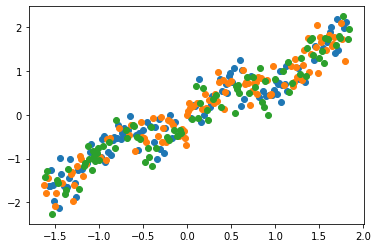

In [122]:
if D1:
    plt.scatter(x_train[:,0], y_train);
    plt.scatter(x_validation[:,0], y_validation);
    plt.scatter(x_test[:,0], y_test);
else:
    plt.scatter(x_train[:,1], y_train);
    plt.scatter(x_validation[:,1], y_validation);
    plt.scatter(x_test[:,1], y_test);
plt.show()

In [123]:
# convert from nparray to Var
def nparray_to_Var(x):
  if x.ndim==1:
    y = [[Var(float(x[i]))] for i in range(x.shape[0])] # always work with list of list
  else:
    y = [[Var(float(x[i,j])) for j in range(x.shape[1])] for i in range(x.shape[0])]
  return y
   
x_train = nparray_to_Var(x_train)
y_train = nparray_to_Var(y_train)
x_validation = nparray_to_Var(x_validation)
y_validation = nparray_to_Var(y_validation)
x_test = nparray_to_Var(x_test)
y_test = nparray_to_Var(y_test)


# Defining and initializing the network

The steps to create a feed forward neural network are the following:

1. **Number of hidden layer and hidden units**. We have to define the number of hidden units in each layer. The number of features in X and the output dimensionality (the size of Y) are given but the numbers in between are set by the researcher. Remember that for each unit in each layer beside in the input has a bias term.
2. **Activation functions** for each hidden layer. Each hidden layer in your list must have an activation function (it can also be the linear activation which is equivalent to identity function). The power of neural networks comes from non-linear activation functions that learn representations (features) from the data allowing us to learn from it. 
3. **Parameter initialization**. We will initialize the weights to have random values. This is done in practice by drawing pseudo random numbers from a Gaussian or uniform distribution. It turns out that for deeper models we have to be careful about how we scale the random numbers. This will be the topic of the exercise below. For now we will just use unit variance Gaussians.  

In order to make life easier for ourselves we define a DenseLayer class that takes care of initialization and the forward pass. We can also extend it later with print and advanced initialization capabilities. For the latter we have introduced a Initializer class.

Note that we use Sequence in the code below. A Sequence is an ordered list. This means the order we insert and access items are the same.

In [124]:
class Initializer:

  def init_weights(self, n_in, n_out):
    raise NotImplementedError

  def init_bias(self, n_out):
    raise NotImplementedError
  
  ## Glorot
  def DenseLayer_Glorot_tanh(n_in: int, n_out: int):
    std = 2/(n_in+n_out) # <- replace with proper initialization
    return DenseLayer(n_in, n_out, lambda x: x.tanh(), initializer = NormalInitializer(std))

  ## He
  def DenseLayer_He_relu(n_in: int, n_out: int):
    std = 2/n_in # <- replace with proper initialization
    return DenseLayer(n_in, n_out, lambda x: x.relu)

In [125]:
import random

class NormalInitializer(Initializer):

  def __init__(self, mean=0, std=0.1):
    self.mean = mean
    self.std = std

  def init_weights(self, n_in, n_out):
    return [[Var(random.gauss(self.mean, self.std)) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(0.0) for _ in range(n_out)]

class ConstantInitializer(Initializer):

  def __init__(self, weight=1.0, bias=0.0):
    self.weight = weight
    self.bias = bias

  def init_weights(self, n_in, n_out):
    return [[Var(self.weight) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(self.bias) for _ in range(n_out)]

In [126]:
from typing import Sequence

class DenseLayer:
    def __init__(self, n_in: int, n_out: int, act_fn, initializer = NormalInitializer()):
        self.weights = initializer.init_weights(n_in, n_out)
        self.bias = initializer.init_bias(n_out)
        self.act_fn = act_fn
    
    def __repr__(self):    
        return 'Weights: ' + repr(self.weights) + ' Biases: ' + repr(self.bias)

    def parameters(self) -> Sequence[Var]:
      params = []
      for r in self.weights:
        params += r

      return params + self.bias

    def forward(self, single_input: Sequence[Var]) -> Sequence[Var]:
        # self.weights is a matrix with dimension n_in x n_out. We check that the dimensionality of the input
        # to the current layer matches the number of nodes in the current layer
        assert len(self.weights) == len(single_input), "weights and single_input must match in first dimension"
        weights = self.weights
        out = []
        # For some given data point single_input, we now want to calculate the resulting value in each node in the current layer
        # We therefore loop over the (number of) nodes in the current layer:
        for j in range(len(weights[0])):
            # Initialize the node value depending on its corresponding parameters.
            node = self.bias[j]  # <- Insert code
            # We now finish the linear transformation corresponding to the parameters of the currently considered node.
            for i in range(len(single_input)):
                node += weights[i][j] * single_input[i]  # <- Insert code
            node = self.act_fn(node)
            out.append(node)

        return out
      
    def describe(self):
        # return f'Input nodes: {self.n_in}, output nodes: {self.n_out} ||' +  f'Weights of input{i}: ' for i in range(len(weights[0]))
        n_out = len(self.weights[0])
        n_in = len(self.weights)
        params = self.parameters()
        description = [[f'Weight from input {j} to node {i}: {params[n_out * j + i]} and bias {params[-(n_out-i)]}' for i
          in range(n_out)] for j in range(n_in)]
        return sum(description, [])

## Exercise f) Add more activation functions

To have a full definition of the neural network, we must define an activation function for every layer. Several activation functions have been proposed and have different characteristics. In the Var class we have already defined the rectified linear init (relu). 
 
Implement the following activation functions in the Var class:

* Identity: $$\mathrm{identity}(x) = x$$
* Hyperbolic tangent: $$\tanh(x)$$
* Sigmoid (or logistic function): $$\mathrm{sigmoid}(x) = \frac{1}{1.0 + \exp(-x ) }$$  Hint: $\mathrm{sigmoid}'(x)= \mathrm{sigmoid}(x)(1-\mathrm{sigmoid}(x))$.  

Hint: You can seek inspiration in the relu method in the Var class.

**Answer (f)**

The following code snippet is implemented in the previous Var class.

In [ ]:
    def sigmoid(self):
        return Var(1/(1+exp(-self.v)), lambda: [(self, exp(self.v)/((exp(self.v)+1)**2))])

    def tanh(self):
        return Var((exp(2*self.v)-1)/(exp(2*self.v)+1), lambda: [(self, 4/((exp(-self.v)+exp(self.v))**2))])

    def identity(self):
        return Var(self.v, lambda: [(self, 1.0)])

## Exercise g) Complete the forward pass

In the code below we initialize a 1-5-1 network and pass the training set through it. *The forward method in DenseLayer is **not** complete*. It just outputs zeros right now. The method forward should perform an [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) on the input followed by an application of the activation function.

In [127]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

def forward(input, network):

  def forward_single(x, network):
    for layer in network:
        x = layer.forward(x)
    return x

  output = [ forward_single(input[n], network) for n in range(len(input))]
  return output

print(forward(x_train, NN))


[[Var(v=-0.0023, grad=0.0000)], [Var(v=-0.0047, grad=0.0000)], [Var(v=-0.0004, grad=0.0000)], [Var(v=-0.0142, grad=0.0000)], [Var(v=-0.0034, grad=0.0000)], [Var(v=-0.0032, grad=0.0000)], [Var(v=-0.0021, grad=0.0000)], [Var(v=-0.0034, grad=0.0000)], [Var(v=-0.0146, grad=0.0000)], [Var(v=-0.0013, grad=0.0000)], [Var(v=-0.0036, grad=0.0000)], [Var(v=-0.0090, grad=0.0000)], [Var(v=-0.0029, grad=0.0000)], [Var(v=-0.0103, grad=0.0000)], [Var(v=-0.0015, grad=0.0000)], [Var(v=-0.0030, grad=0.0000)], [Var(v=-0.0055, grad=0.0000)], [Var(v=-0.0026, grad=0.0000)], [Var(v=-0.0003, grad=0.0000)], [Var(v=-0.0009, grad=0.0000)], [Var(v=-0.0068, grad=0.0000)], [Var(v=-0.0030, grad=0.0000)], [Var(v=-0.0040, grad=0.0000)], [Var(v=-0.0041, grad=0.0000)], [Var(v=-0.0040, grad=0.0000)], [Var(v=-0.0106, grad=0.0000)], [Var(v=-0.0052, grad=0.0000)], [Var(v=-0.0057, grad=0.0000)], [Var(v=-0.0006, grad=0.0000)], [Var(v=-0.0036, grad=0.0000)], [Var(v=-0.0133, grad=0.0000)], [Var(v=-0.0009, grad=0.0000)], [Var(v=

**Answer (g)**

The following code snippet has been implemented ind the previous DenseLayer Class, as the function forward.

In [ ]:
def forward(self, single_input: Sequence[Var]) -> Sequence[Var]:
    # self.weights is a matrix with dimension n_in x n_out. We check that the dimensionality of the input
    # to the current layer matches the number of nodes in the current layer
    assert len(self.weights) == len(single_input), "weights and single_input must match in first dimension"
    weights = self.weights
    out = []
    # For some given data point single_input, we now want to calculate the resulting value in each node in the current layer
    # We therefore loop over the (number of) nodes in the current layer:
    for j in range(len(weights[0])):
        # Initialize the node value depending on its corresponding parameters.
        node = self.bias[j]  # <- Insert code
        # We now finish the linear transformation corresponding to the parameters of the currently considered node.
        for i in range(len(single_input)):
            node += weights[i][j] * single_input[i]  # <- Insert code
        node = self.act_fn(node)
        out.append(node)

## Exercise h) Print all network parameters

Make a function that prints all the parameters of the network (weights and biases) with information about in which layer the appear. In the object oriented spirit you should introduce a method in the DenseLayer class to print the parameters of a layer. Hint: You can take inspiration from the corresponding method in Var. 

**Answer (h)**

The following code snippet has been implemented in the DenseLayer class. The intended behaviour, is that a .describe() call would show a string describing the weight from an input to the connected node, and the bias.

In [ ]:
    def describe(self):
        # return f'Input nodes: {self.n_in}, output nodes: {self.n_out} ||' +  f'Weights of input{i}: ' for i in range(len(weights[0]))
        n_out = len(self.weights[0])
        n_in = len(self.weights)
        params = self.parameters()
        description = [[f'Weight from input {j} to node {i}: {params[n_out * j + i]} and bias {params[-(n_out-i)]}' for i
          in range(n_out)] for j in range(n_in)]
        return sum(description, [])

And for this following code snippet, the neural network is described in full, assuming the input is of the format of the previously used definition of NN, which is a list of DenseLayer class calls.

In [128]:
def describe_NN(NN):
  for i, j in enumerate(NN):
    if i==0:
      print(f'Layer {i} (input) to {i+1}:')
    elif i==len(NN)-1:
      print(f'Layer {i} to {i+1} (output):')
    else:
      print(f'Layer {i} to {i+1}:')
    for x in j.describe():
        print(x)

describe_NN(NN=NN)

Layer 0 (input) to 1:
Weight from input 0 to node 0: Var(v=0.1201, grad=0.0000) and bias Var(v=0.0000, grad=0.0000)
Weight from input 0 to node 1: Var(v=0.0575, grad=0.0000) and bias Var(v=0.0000, grad=0.0000)
Weight from input 0 to node 2: Var(v=-0.0978, grad=0.0000) and bias Var(v=0.0000, grad=0.0000)
Weight from input 0 to node 3: Var(v=0.1245, grad=0.0000) and bias Var(v=0.0000, grad=0.0000)
Weight from input 0 to node 4: Var(v=0.0589, grad=0.0000) and bias Var(v=0.0000, grad=0.0000)
Layer 1 to 2 (output):
Weight from input 0 to node 0: Var(v=-0.0520, grad=0.0000) and bias Var(v=0.0000, grad=0.0000)
Weight from input 1 to node 0: Var(v=0.0771, grad=0.0000) and bias Var(v=0.0000, grad=0.0000)
Weight from input 2 to node 0: Var(v=-0.0954, grad=0.0000) and bias Var(v=0.0000, grad=0.0000)
Weight from input 3 to node 0: Var(v=0.0339, grad=0.0000) and bias Var(v=0.0000, grad=0.0000)
Weight from input 4 to node 0: Var(v=-0.0954, grad=0.0000) and bias Var(v=0.0000, grad=0.0000)


## Visualization

Now that we have defined our activation functions we can visualize them to see what they look like:

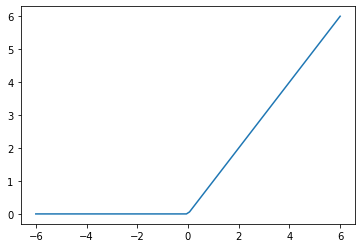

In [129]:
x = np.linspace(-6, 6, 100)

# convert from Var to ndarray  
def Var_to_nparray(x):
  y = np.zeros((len(x),len(x[0])))
  for i in range(len(x)):
    for j in range(len(x[0])):
      y[i,j] = x[i][j].v
  return y

# define 1-1 network with weight = 1 and relu activation 
NN = [ DenseLayer(1, 1, lambda x: x.relu(), initializer = ConstantInitializer(1.0)) ] 
y = Var_to_nparray(forward(nparray_to_Var(x), NN))

#y = Var_to_nparray(relu(nparray_to_Var(x)))
plt.plot(x,y)

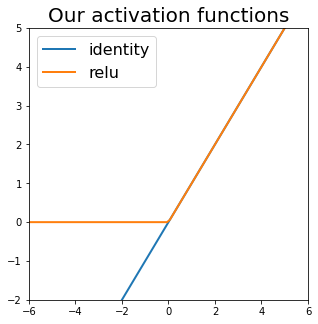

In [130]:
# Testing all activation layers

x = np.linspace(-6, 6, 100)
units = {
    "identity": lambda x: x.identity(),
    #"sigmoid": lambda x: x.sigmoid(),  <- uncomment before sharing
    "relu": lambda x: x.relu(),
    #"tanh": lambda x: x.tanh() <- uncomment before sharing
}

plt.figure(figsize=(5, 5))
[plt.plot(x, Var_to_nparray(forward(nparray_to_Var(x), [DenseLayer(1, 1, unit, initializer = ConstantInitializer(1.0))]) ), label=unit_name, lw=2) for unit_name, unit in units.items()] # unit(nparray_to_Var(x))), label=unit_name, lw=2) for unit_name, unit in units.items()]
plt.legend(loc=2, fontsize=16)
plt.title('Our activation functions', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])
plt.show()

# Advanced initialization schemes

If we are not careful with initialization, the signals we propagate forward ($a^{(l)}$, $l=1,\ldots,L$) and backward ($\delta^l$, $l=L,L-1,\ldots,1$) can blow up or shrink to zero. A statistical analysis of the variance of the signals for different activation functions can be found in these two papers: [Glorot initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) and [He initialization](https://arxiv.org/pdf/1502.01852v1.pdf). 

The result of the analyses are proposals for how to make the initialization such that the variance of the signals (forward and backward) are kept approxmimatly constant when propagating from layer to layer. The exact expressions depend upon the non-linear activation function used. In Glorot initialization, the aim is to keep both the forward and backward variances constant whereas He only aims at keeping the variance in the forward pass constant.

We define $n_{in}$ and $n_{out}$ as the number of input units and output units of a particular layer. 

The Glorot initialization has the form: 

$$w_{ij} \sim N \bigg( 0, \, \frac{2 \alpha }{n_{in} + n_{out}} \bigg) \ . $$

where $N(\mu,\sigma^2)$ is a Gaussian distribution with mean $\mu$ and variance $\sigma^2$ and $\alpha$ is a parameter that depends upon the activation function used. For $\tanh$, $\alpha=1$ and for Rectified Linear Unit (ReLU) activations, $\alpha=2$. (It is also possible to use a uniform distribution for initialization, see [this blog post](https://mmuratarat.github.io/2019-02-25/xavier-glorot-he-weight-init).) 

The He initialization is very similar

$$w_{ij} \sim N \bigg( 0, \, \frac{\alpha}{n_{in}} \bigg) \ . $$

## Exercise i) Glorot and He initialization
 
Using the Initializer class, implement functions that implement Glorot and He 

Explain briefly how you would test numerically that these initializations have the sought after property. Hint: See plots in Glorot paper.

Comment: If you want to be more advanced then try to make a universal initializer taking both the activation function and type (Glorot or He) as argument.

**Answer (i)**

Below is the code snippet of the attempt at implementing the Glorot and He initialization schemes. These are also found implemented in the Initializer class from before.

A numerical test would simply be to plot the activation values of each layer, which should result in very alike distributions around 0 mean (see figure 6 of the Glorot paper). Additionally, if it holds, the ratio between ${\mathbf z^i}$ to ${\mathbf z^{i+1}}$ should be around 0.8, and 0.5 for the more common method ($1/\sqrt(n)$) (see the Glorot paper section 4.2.2).

In [131]:
## Glorot
def DenseLayer_Glorot_tanh(n_in: int, n_out: int):
  std = 2/(n_in+n_out) # <- replace with proper initialization
  return DenseLayer(n_in, n_out, lambda x: x.tanh(), initializer = NormalInitializer(std))

## He
def DenseLayer_He_relu(n_in: int, n_out: int):
  std = 2/n_in # <- replace with proper initialization
  return DenseLayer(n_in, n_out, lambda x: x.relu(), initializer = NormalInitializer(std))

def DenseLayer_init(n_in: int, n_out: int, act_fn, init_type: str=None):
  assert init_type in ['Glorot', 'He'], f"Choose initialization type. Must be either 'Glorot' or 'He'"
  if init_type == 'Glorot':
    alpha = 1
    std = 2*alpha/(n_in+n_out)
  elif init_type == 'He':
    alpha = 2
    std = alpha/n_in
  return DenseLayer(n_in, n_out, act_fn, initializer = NormalInitializer(std))

## Exercise j) Forward pass unit test

Write a bit of code to make a unit test that the forward pass works. This can be done by defining a simple network with for example all weights equal to one (using the ConstantInitializer method) and identity activation functions. 

Hints: Use the [assert](https://www.w3schools.com/python/ref_keyword_assert.asp), the nparray_to_Var and the Var_to_nparray commands. 

**Answer (j)**

For the unit test a simple 1-2-1 layer network is made, with the ConstantInitializer initializer, and the identity activation function, for both in and out of the hidden layer of 2 nodes. This means the weights will remain 1, and the activation will be the input itself. Therefore the output layer will output half the value of the input, which then will be tested for, seen below.

In [132]:
UT_NN = [
    DenseLayer(1, 2, lambda x: x.identity(), initializer=ConstantInitializer()),
    DenseLayer(2, 1, lambda x: x.identity(), initializer=ConstantInitializer())
]

input_values = Var_to_nparray(x_train[:5])
test_nn_results = forward(x_train[:5], UT_NN)
adjusted_test_nn_results = Var_to_nparray([[i[0]*Var(0.5)] for i in test_nn_results])
assert all(input_values == adjusted_test_nn_results)

# Loss functions

We are only missing a loss function to we need to define a loss function and its derivative with respect to the output of the neural network $y$

In [133]:
def squared_loss(t, y):
  
  # add check that sizes agree
  
  def squared_loss_single(t, y):
    Loss = Var(0.0)
    for i in range(len(t)): # sum over outputs
      Loss += (t[i]-y[i]) ** 2
    return Loss

  Loss = Var(0.0)
  for n in range(len(t)): # sum over training data
    Loss += squared_loss_single(t[n],y[n])
  return Loss

## Exercise k) Implement cross entropy loss

Insert code below to implement cross-entropy loss for general dimensionality of $t$. Use a logits formulation:
$$
\rm{Loss} = - \sum_i t_i \, log \, p_i 
$$
with $p$ given by the the softmax function in terms of the logits $h$:
$$
p_i = \frac{\exp(h_i)}{\sum_{i'} \exp(h_{i'})} .
$$
Inserting $p$ in the expression for the loss gives
$$
\rm{Loss} = - \sum_i t_i h_i + \rm{LogSumExp}(h) \ ,
$$
where 
$$
\rm{LogSumExp}(h) = \log \sum_i \exp h_i \ .
$$
This is true for $t$ being a one-hot vector. 

Call the function to convince yourself it works. 

In practice you want to implement a [numerically stable](https://leimao.github.io/blog/LogSumExp/) version of LogSumExp. But we will not bother about that here.

Help: You can add these methods in the Var class:

    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

**Answer (k)**

Below is the implemented cross_entropy_loss function. With the aforementioned hint, where an expression for log and exp has been implemented in the Var class, these are used for easier calculation.

In [134]:
def cross_entropy_loss_single(t,h):
  Loss_1 = Var(0.0)
  Loss_2 = Var(0,0)
  for i in range(len(t)):
    Loss_1 += -t[i]*h[i]
    Loss_2 += h[i].exp()
  Loss = Loss_1+Loss_2.log()
  return Loss


# Backward pass

Now the magic happens! We get the calculation of the gradients for free. Just do:

In [135]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

and the gradients will be calculated:

In [91]:
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Layer 0 
 Weights: [[Var(v=0.0450, grad=-13.6451), Var(v=0.0904, grad=-9.4624), Var(v=-0.0743, grad=-8.2226), Var(v=0.0144, grad=2.5502), Var(v=0.1141, grad=-7.0948)]] Biases: [Var(v=0.0000, grad=-11.7266), Var(v=0.0000, grad=-8.1320), Var(v=0.0000, grad=7.4748), Var(v=0.0000, grad=2.1916), Var(v=0.0000, grad=-6.0973)]
Layer 1 
 Weights: [[Var(v=0.1377, grad=-4.4575)], [Var(v=0.0955, grad=-8.9583)], [Var(v=0.0851, grad=7.1842)], [Var(v=-0.0257, grad=-1.4310)], [Var(v=0.0716, grad=-11.3097)]] Biases: [Var(v=0.0000, grad=2.6806)]


[None, None]

# Backward pass unit test

Above we used finite differences to test that Nanograd is actually doing what it is supposed to do. We can in principle try the same for the neural network. But we will trust that the test above is enough.

# Training and validation

We are ready to train some neural networks!

We initialize again:

In [136]:
NN = [
    DenseLayer(1, 15, lambda x: x.relu()),
    DenseLayer(15, 50, lambda x: x.relu()),
    DenseLayer(50, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

and make an update:

We introduce a help function parameters to have a handle in all parameters in the network.

In [139]:
print('Network before update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

def parameters(network):
  params = []
  for layer in range(len(network)):
    params += network[layer].parameters()
  return params

def update_parameters(params, learning_rate=0.01):
  for p in params:
    p.v -= learning_rate*p.grad

def zero_gradients(params):
  for p in params:
    p.grad = 0.0

update_parameters(parameters(NN))

print('\nNetwork after update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

zero_gradients(parameters(NN))

print('\nNetwork after zeroing gradients:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Network before update:
Layer 0 
 Weights: [[Var(v=0.1520, grad=0.0000), Var(v=-0.0293, grad=0.0000), Var(v=-0.0644, grad=0.0000), Var(v=-0.0390, grad=0.0000), Var(v=-0.0217, grad=0.0000), Var(v=-0.1387, grad=0.0000), Var(v=0.0593, grad=0.0000), Var(v=-0.0913, grad=0.0000)]] Biases: [Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000)]
Layer 1 
 Weights: [[Var(v=-0.1138, grad=0.0000)], [Var(v=0.0110, grad=0.0000)], [Var(v=0.0123, grad=0.0000)], [Var(v=0.1022, grad=0.0000)], [Var(v=0.0137, grad=0.0000)], [Var(v=0.2756, grad=0.0000)], [Var(v=0.1313, grad=0.0000)], [Var(v=-0.1195, grad=0.0000)]] Biases: [Var(v=0.0000, grad=0.0000)]

Network after update:
Layer 0 
 Weights: [[Var(v=0.1520, grad=0.0000), Var(v=-0.0293, grad=0.0000), Var(v=-0.0644, grad=0.0000), Var(v=-0.0390, grad=0.0000), Var(v=-0.0217, grad=0.0000), Var(v

[None, None]

In [140]:
# Initialize an arbitrary neural network
NN = [
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]

# Recommended hyper-parameters for 3-D: 
#NN = [
#    DenseLayer(3, 16, lambda x: x.relu()),
#    DenseLayer(16, 1, lambda x: x.identity())
#]


### Notice that, when we switch from tanh to relu activation, we decrease the learning rate. This is due the stability of the gradients 
## of the activation functions.

In [141]:
# Initialize training hyperparameters
EPOCHS = 200
LEARN_R = 2e-3 

In [142]:
train_loss = []
val_loss = []

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
        


   0 ( 0.00%) Train loss: 104.162 	 Validation loss: 102.591
  10 ( 5.00%) Train loss: 21.224 	 Validation loss: 17.020
  20 (10.00%) Train loss: 13.803 	 Validation loss: 10.882
  30 (15.00%) Train loss: 13.294 	 Validation loss: 10.246
  40 (20.00%) Train loss: 12.978 	 Validation loss: 9.821
  50 (25.00%) Train loss: 12.719 	 Validation loss: 9.463
  60 (30.00%) Train loss: 12.508 	 Validation loss: 9.207
  70 (35.00%) Train loss: 12.364 	 Validation loss: 9.103
  80 (40.00%) Train loss: 12.258 	 Validation loss: 9.030
  90 (45.00%) Train loss: 12.183 	 Validation loss: 8.979
 100 (50.00%) Train loss: 12.119 	 Validation loss: 8.945
 110 (55.00%) Train loss: 12.061 	 Validation loss: 8.943
 120 (60.00%) Train loss: 11.982 	 Validation loss: 8.940
 130 (65.00%) Train loss: 11.944 	 Validation loss: 8.950
 140 (70.00%) Train loss: 11.928 	 Validation loss: 8.952
 150 (75.00%) Train loss: 11.913 	 Validation loss: 8.964
 160 (80.00%) Train loss: 11.906 	 Validation loss: 8.973
 170 (85

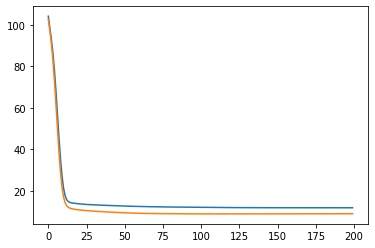

In [143]:
plt.plot(range(len(train_loss)), train_loss);
plt.plot(range(len(val_loss)), val_loss);

# Testing

We have kept the calculation of the test error separate in order to emphasize that you should not use the test set in optimization.

In [144]:
output_test = forward(x_test, NN)

Test loss:  9.793


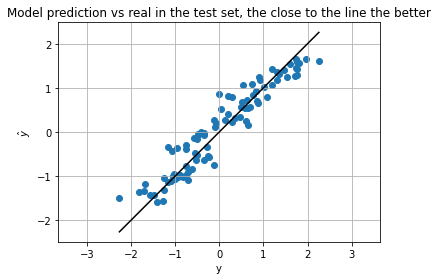

In [145]:
y_test_np = Var_to_nparray(y_test)
plt.scatter(y_test_np, Var_to_nparray(output_test));
plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

Loss_test = squared_loss(y_test, forward(x_test, NN))

print("Test loss:  {:4.3f}".format(Loss_test.v))

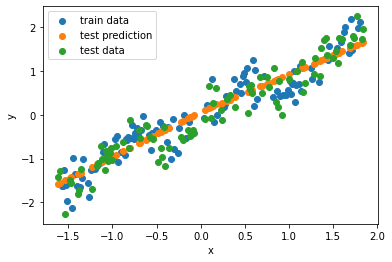

In [146]:
x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, Var_to_nparray(output_test), label="test prediction");
    plt.scatter(x_test_np, y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
else:
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    plt.scatter(x_test_np[:,1], Var_to_nparray(output_test), label="test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");

## Exercise l) Show overfitting, underfitting and just right fitting

Vary the architecture and other things to show clear signs of overfitting (=training loss significantly lower than test loss) and underfitting (=not fitting enoung to training data so that test performance is also hurt).

See also if you can get a good compromise which leads to a low validation loss. 

For this problem do you see any big difference between validation and test loss? The answer here will probably be no. Discuss cases where it is important to keep the two separate.

_Insert written answer here._


   0 ( 0.00%) Train loss: 104.085 	 Validation loss: 101.119
   0 ( 0.00%) Train loss: 105.987 	 Validation loss: 106.651
  10 ( 5.00%) Train loss: 52.570 	 Validation loss: 38.953
  20 (10.00%) Train loss: 15.139 	 Validation loss: 11.252
  30 (15.00%) Train loss: 14.492 	 Validation loss: 10.701
  40 (20.00%) Train loss: 13.847 	 Validation loss: 10.370
  50 (25.00%) Train loss: 12.973 	 Validation loss: 9.837
  60 (30.00%) Train loss: 12.554 	 Validation loss: 9.478
  70 (35.00%) Train loss: 12.335 	 Validation loss: 9.274
  80 (40.00%) Train loss: 12.173 	 Validation loss: 9.180
  90 (45.00%) Train loss: 12.066 	 Validation loss: 9.064
 100 (50.00%) Train loss: 12.010 	 Validation loss: 9.006
 110 (55.00%) Train loss: 11.973 	 Validation loss: 8.962
 120 (60.00%) Train loss: 11.949 	 Validation loss: 8.940
 130 (65.00%) Train loss: 11.933 	 Validation loss: 8.921
 140 (70.00%) Train loss: 11.922 	 Validation loss: 8.915
 150 (75.00%) Train loss: 11.911 	 Validation loss: 8.936
 160

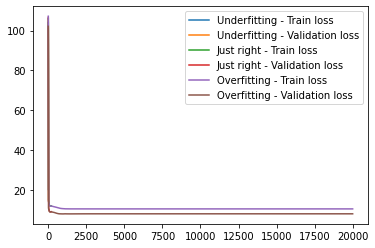

In [171]:
params = [(10, 2e-3), (200,2e-3), (20000, 2e-3)]
NNs = []
train_losses = []
val_losses = []
for (EPOCHS, LEARN_R) in params:
  NN = [
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]
  train_loss = []
  val_loss = []

  for e in range(EPOCHS):
      
      # Forward pass and loss computation
      Loss = squared_loss(y_train, forward(x_train, NN))

      # Backward pass
      Loss.backward()
      
      # gradient descent update
      update_parameters(parameters(NN), LEARN_R)
      zero_gradients(parameters(NN))
      
      # Training loss
      train_loss.append(Loss.v)
      
      # Validation
      Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
      val_loss.append(Loss_validation.v)
      
      if e%10==0:
          print("{:4d}".format(e),
                "({:5.2f}%)".format(e/EPOCHS*100), 
                "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
  NNs.append(NN)
  train_losses.append(train_loss)
  val_losses.append(val_loss)

types = ['Underfitting', 'Just right', 'Overfitting']
output_tests = []
for i in range(len(NNs)):
  output_tests.append(forward(x_test, NNs[i]))
  plt.plot(range(len(train_losses[i])), train_losses[i], label=f'{types[i]} - Train loss');
  plt.plot(range(len(val_losses[i])), val_losses[i], label=f'{types[i]} - Validation loss');
plt.legend()

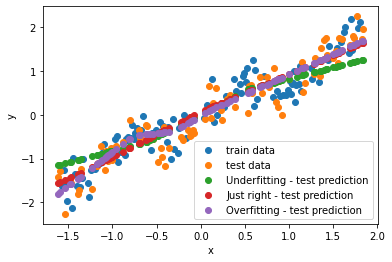

In [172]:
x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, y_test_np, label="test data");
    for x in range(len(output_tests)):
      plt.scatter(x_test_np, Var_to_nparray(output_tests[x]), label=f"{types[x]} - test prediction");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
else:
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    for x in range(len(output_tests)):
      plt.scatter(x_test_np[:,1], Var_to_nparray(output_tests[x]), label=f"{types[x]} - test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");

# Next steps - classification

It is straight forward to extend what we have done to classification. 

For numerical stability it is better to make softmax and cross-entropy as one function so we write the cross entropy loss as a function of the logits we talked about last week. 

Next week we will see how to perform classification in PyTorch.

## Exercise m) optional - Implement backpropagation for classification

Should be possible with very few lines of code. :-)

In [ ]:
# Just add code.

## Exercise n) optional - Introduce a NeuralNetwork class

The functions we applied on the neural network (parameters, update_parameters and zero_gradients) can more naturally be included as methods in a NeuralNetwork class. Make such a class and modify the code to use it. 

In [ ]:
# just add some code